# Sprawozdanie
**Z projektu dotyczącego predykcji szeregów czasowych** \
*Autor: Ewa Szewczyk, nr indeksu: 406923*

Celem projektu było przeprowadzenie analizy i predykcji szeregów czasowych dotyczących poziomu pyłu zawieszonego przy użyciu modelu XGBoost.

<div style="text-align: justify"> W projekcie wykorzystano dane udostępnione przez GIOŚ (Główny Inspektorat Ochrony Środowiska) za rok 2019 dotyczące pomiarów PM2.5 w godzinnych odstępach. Do zlokalizowania stacji wykorzystano plik udostępniany przez GIOŚ zawierający takie informacje jak współrzędne geograficzne, adres, województwo czy rodzaj stacji pomiarowej.</div>

### Ustawienia notatnika

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

sns.set_theme("notebook")
sns.set_palette("tab20b")

## Część 1: Przygotowanie danych i inżynieria cech

### Wczytanie danych i dodanie cech (przestrzennych)
Pierwszym etapem prac było wczytanie danych, poprawienie nazw kolumn oraz połączenie danych pomiarowych z lokalizacjami poszczególnych stacji.

In [2]:
# Wczytanie danych pomiarowych

# Wczytanie danych z excela
pm_df = pd.read_excel("2019_PM25_1g.xlsx", skiprows=5).melt(
    id_vars=["Kod stanowiska"], var_name="station_code", value_name="PM25"
)

pm_df = pm_df.rename(columns={"Kod stanowiska": "date"})
pm_df["station_code"] = pm_df.station_code.str[:-9]

# Mapowanie przestarzałych nazw stacji
stations_mapper = {
    "LbNaleczow": "LbNaleczAlMa",
    "MzKonJezMos": "MzKonJezWieMOB",
    "PdSuwPulaskp": "PdSuwPulask2",
    "PmGdaLeczk08": "PmGdaLeczkow",
    "ZpSzczAndr01": "ZpSzczAndrze",
    "ZpSzczPils02": "ZpSzczPilsud",
}
pm_df["station_code"] = pm_df.station_code.replace(stations_mapper)

pm_df.head()

,date,station_code,PM25
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722


In [3]:
# Wczytanie lokalizacji stacji pomiarowych
colnames = [
    "N",
    "station_code",
    "international_code",
    "name",
    "old_station_code",
    "date_opening",
    "date_closing",
    "station_type",
    "region_type",
    "station_location_type",
    "voivodeship",
    "city",
    "address",
    "lat",
    "lon",
]

loc_df = pd.read_excel(
    "Metadane oraz kody stacji i stanowisk pomiarowych.xlsx",
    index_col=0,
    names=colnames,
)

# Usunięcie z ramki danych stacji które zostały wyłączone z użytku przed badanym okresem
loc_df = loc_df[
    (loc_df.date_closing >= "2019-01-01") | (loc_df.date_closing.isna())
].reset_index(drop=True)
loc_df.head()

,station_code,international_code,name,old_station_code,date_opening,date_closing,station_type,region_type,station_location_type,voivodeship,city,address,lat,lon
0,DsCzerStraza,PL0028A,Czerniawa,DsCzer02,1996-07-01,NaT,tło,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Czerniawa,ul. Strażacka 7,50.912475,15.312190
1,DsDusznikMOB,PL0733A,Duszniki-Zdrój,NaN,2019-01-01,2019-12-31,tło,miejski,mobilna,DOLNOŚLĄSKIE,Duszniki-Zdrój,Sportowa 2a,50.402645,16.393319
2,DsDzialoszyn,PL0054A,Działoszyn,DsDzia01,1996-07-01,2022-12-31,przemysłowa,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Działoszyn,NaN,50.972167,14.941319
3,DsDziePilsud,PL0187A,"Dzierżoniów, ul. Piłsudskiego",DsDzierPilsA,2005-01-01,NaT,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Dzierżoniów,ul. Piłsudskiego 26,50.732817,16.648050
4,DsGlogWiStwo,PL0603A,"Głogów, ul. Wita Stwosza",DsGlogWita,2015-01-01,NaT,tło,miejski,wolnostojący pobornik pyłu,DOLNOŚLĄSKIE,Głogów,ul. Wita Stwosza 3,51.657022,16.097822


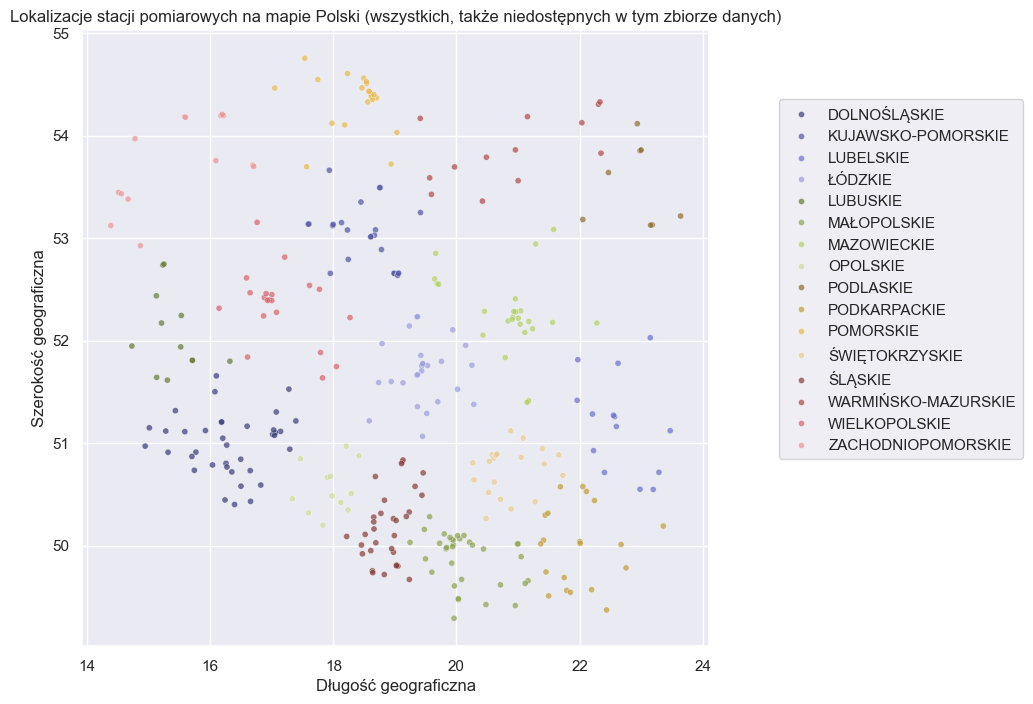

In [4]:
# Wizualizacja lokalizacji stacji

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.scatterplot(loc_df, x="lon", y="lat", alpha=0.7, s=20, hue="voivodeship")
ax.set(
    aspect=5 / 3,
    title="Lokalizacje stacji pomiarowych na mapie Polski (wszystkich, także niedostępnych w tym zbiorze danych)",
    xlabel="Długość geograficzna",
    ylabel="Szerokość geograficzna",
)

ax.legend(bbox_to_anchor=(1.1, 0.9))

plt.show()

Na powyższym wykresie można zobaczyć wszystkie stacje pomiarowe które są w posiadaniu GIOŚ. Nie wszystkie z nich pobierają dane dotyczące zanieczyszczenia powietrza pyłami PM10, w związku z czym po ich połączeniu z danymi pomiarowymi ilość dostępnych stacji może ulec zmianie.

In [5]:
# Łączenie danych pomiarowych i lokalizacyjnych

print(f"Ilość rekordów w danych pomiarowych PM2.5: {len(pm_df)}")
pm_loc_df = pm_df.merge(loc_df, how="inner", on="station_code")
print(
    f"Ilość rekordów po połączeniu danych pomiarowych z lokalizacjami stacji: {len(pm_loc_df)}"
)

Ilość rekordów w danych pomiarowych PM2.5: 551880
Ilość rekordów po połączeniu danych pomiarowych z lokalizacjami stacji: 551880


Sprawdzono, czy po połączeniu danych pomiarowych i lokalizacyjnych nie zostały utracone żadne dane. W trakcie początkowych badań wykryto w ten sposób inne kody stacji pomiarowych pomiędzy plikiem pomiarowym i lokalizacyjnym (zostało to zaadresowane w komórce "Wczytanie danych pomiarowych").

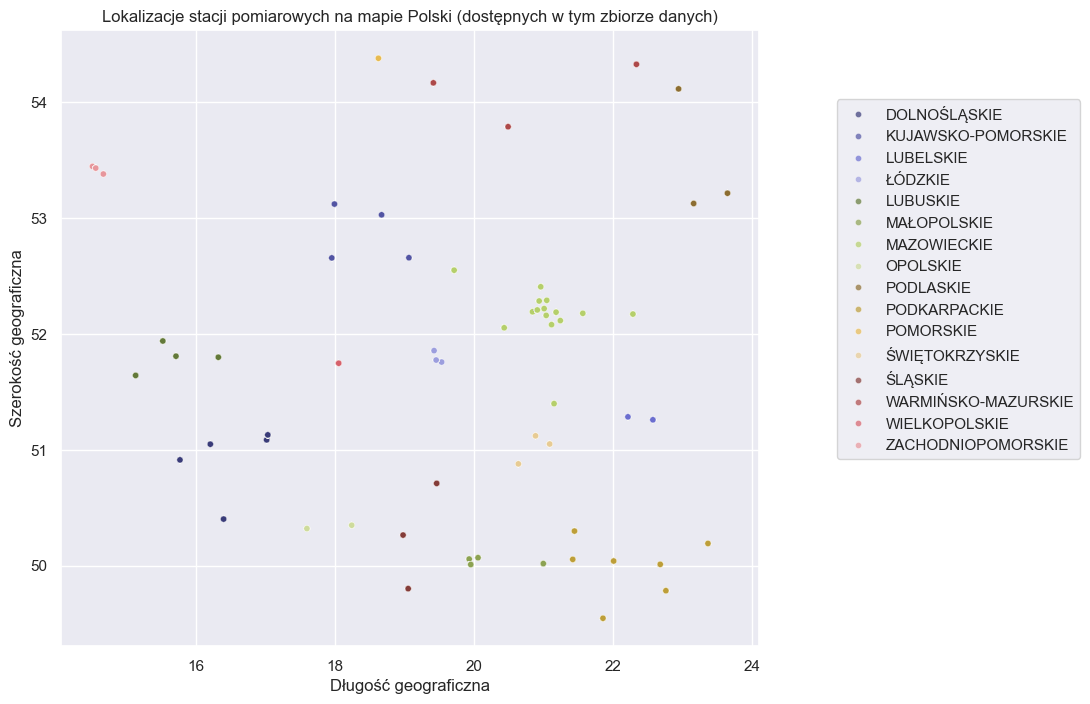

In [6]:
# Wizualizacja lokalizacji stacji (po połączeniu)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.scatterplot(
    pm_loc_df, x="lon", y="lat", alpha=0.7, s=20, hue="voivodeship", palette="tab20b"
)
ax.set(
    aspect=5 / 3,
    title="Lokalizacje stacji pomiarowych na mapie Polski (dostępnych w tym zbiorze danych)",
    xlabel="Długość geograficzna",
    ylabel="Szerokość geograficzna",
)

ax.legend(bbox_to_anchor=(1.1, 0.9))

plt.show()

Po połączeniu ramek danych ilość stacji z których są pomiary uległa zmniejszeniu. W szczególności warto zwrócić uwagę na województwo pomorskie, w którym dostępne są dane jedynie z jednej stacji pomiarowej.

In [7]:
cols_to_save = [
    "date",
    "station_code",
    "PM25",
    "station_type",
    "region_type",
    "station_location_type",
    "voivodeship",
    "lat",
    "lon",
]


df = pm_loc_df[cols_to_save]


df.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319


Z otrzymanej ramki danych usunięto kolumny, które nie są przydatne dla dalszej analizy, czyli:
- międzynarodowy kod stacji - kolumna 'station code' jednoznacznie identyfikuje stację, nie jest potrzebna do tego dodatkowa kolumna,
- nazwa - jak wyżej
- stary kod stacji - potrzebne informacje z tej kolumny zostały już wykorzystane
- data początku działania stacji - nie wpływa to w żaden sposób na wartości pomiarów
- data końca działania stacji - potrzebne informacje z tej kolumny zostały już wykorzystanie, nie wpływa ona na wartości pomiarów
- miasto - lokalizacja może być stwierdzona w dokładniejszy sposób przy użyciu współrzędnych geograficznych
- adres - lokalizacja może być stwierdzona w dokładniejszy sposób przy użyciu współrzędnych geograficznych

### EDA
Następnie przeprowadzono eksploracyjną analizę danych.

In [8]:
print(f"Ilość stacji z których są pomiary: {len(df.station_code.unique())}")
print(
    f'Ilość rodzajów stacji: {len(df.station_type.unique())}: {", ".join(df.station_type.unique())}'
)


print("Ilość pomiarów dla poszczególnych typów stacji:\n")
print(df.station_type.value_counts())

print(
    f'\nIlość rodzajów regionów: {len(df.region_type.unique())}: {", ".join(df.region_type.unique())}'
)


print("Ilość pomiarów dla poszczególnych regionów:\n")


print(df.region_type.value_counts())

Ilość stacji z których są pomiary: 63
Ilość rodzajów stacji: 3: tło, komunikacyjna, przemysłowa
Ilość pomiarów dla poszczególnych typów stacji:

station_type
tło              464280
komunikacyjna     78840
przemysłowa        8760
Name: count, dtype: int64

Ilość rodzajów regionów: 3: miejski, podmiejski, pozamiejski
Ilość pomiarów dla poszczególnych regionów:

region_type
miejski        473040
podmiejski      61320
pozamiejski     17520
Name: count, dtype: int64


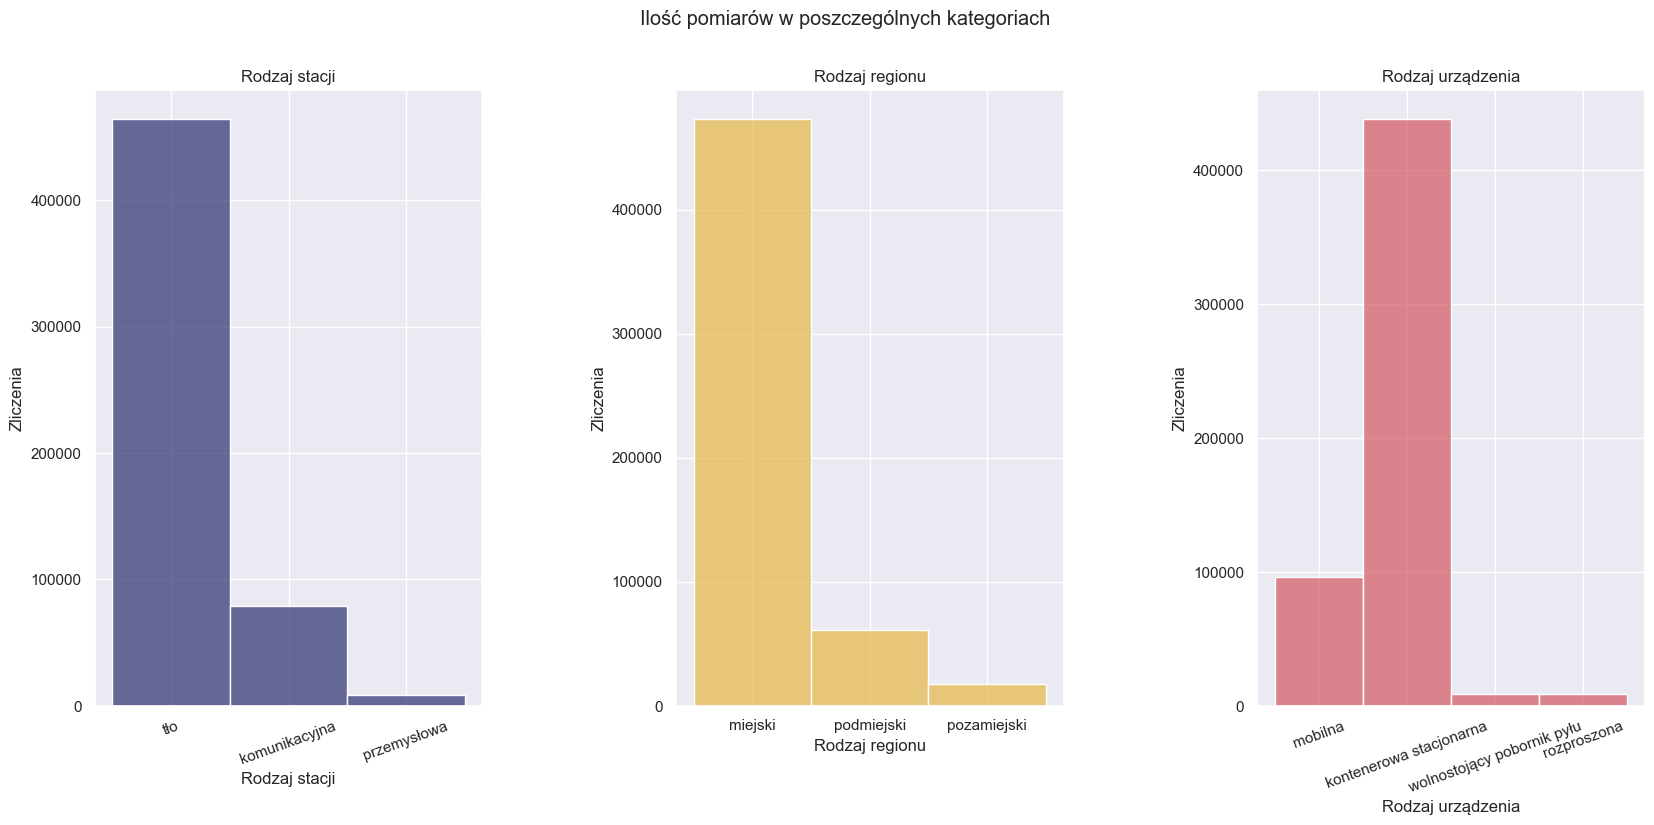

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(df.station_type, ax=axes[0], color=mpl.colormaps["tab20b"](0))
sns.histplot(df.region_type, ax=axes[1], color=mpl.colormaps["tab20b"](0.5))
sns.histplot(df.station_location_type, ax=axes[2], color=mpl.colormaps["tab20b"](0.7))

axes[0].tick_params(axis="x", labelrotation=20)
axes[2].tick_params(axis="x", labelrotation=20)

axes[0].set(xlabel="Rodzaj stacji", ylabel="Zliczenia", title="Rodzaj stacji")
axes[1].set(xlabel="Rodzaj regionu", ylabel="Zliczenia", title="Rodzaj regionu")
axes[2].set(xlabel="Rodzaj urządzenia", ylabel="Zliczenia", title="Rodzaj urządzenia")

fig.suptitle("Ilość pomiarów w poszczególnych kategoriach")

plt.subplots_adjust(wspace=0.5)

plt.show()

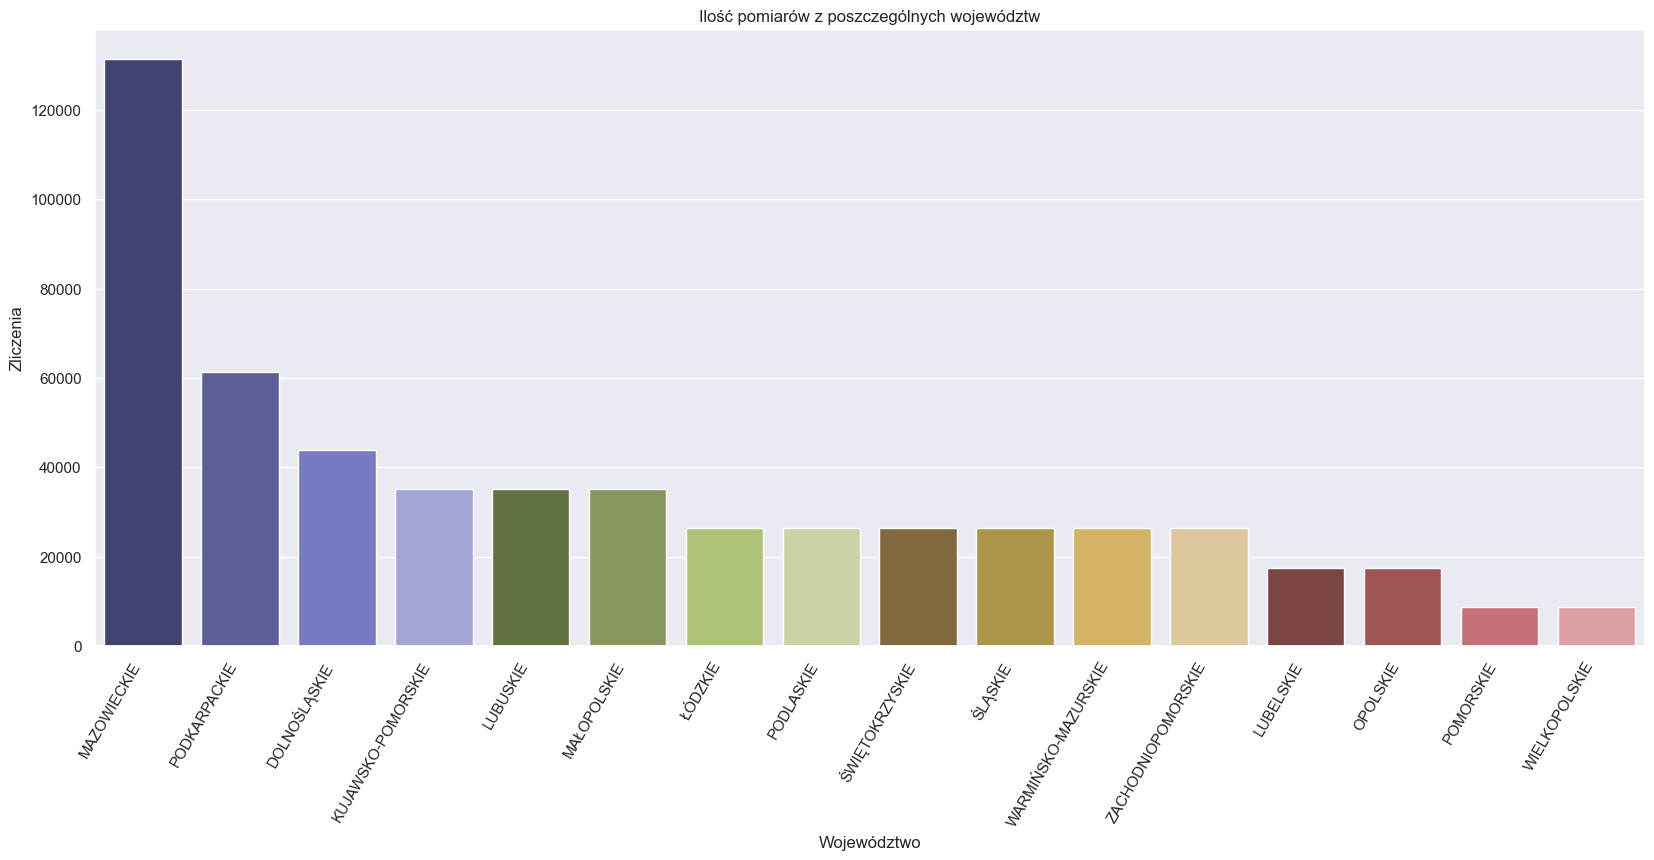

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

v = df.voivodeship.value_counts()

sns.barplot(x=v.index, y=v.values, hue=v.index)
ax.set(
    title="Ilość pomiarów z poszczególnych województw",
    xlabel="Województwo",
    ylabel="Zliczenia",
)

plt.xticks(rotation=60, ha="right")
plt.show()

Na powyższych wykresach przedstawiono:
- Ilości pomiarów dla poszczególnych:
    - rodzajów stacji
    - rodzajów regionów
    - rodzajów urządzenia
- Ilości pomiarów dla poszczególnych województw

Wcześniej sprawdzono również ilość stacji z których pochodzą pomiary - 63. 

Większość stacji położona jest na terenie miejskim, typem urządzenia jest kontener stacjonarny a rodzaj środowiska w jakim się znajduje to "tło" - ani nie jest ona zlokalizowana przy fabryce, ani przy drodze.

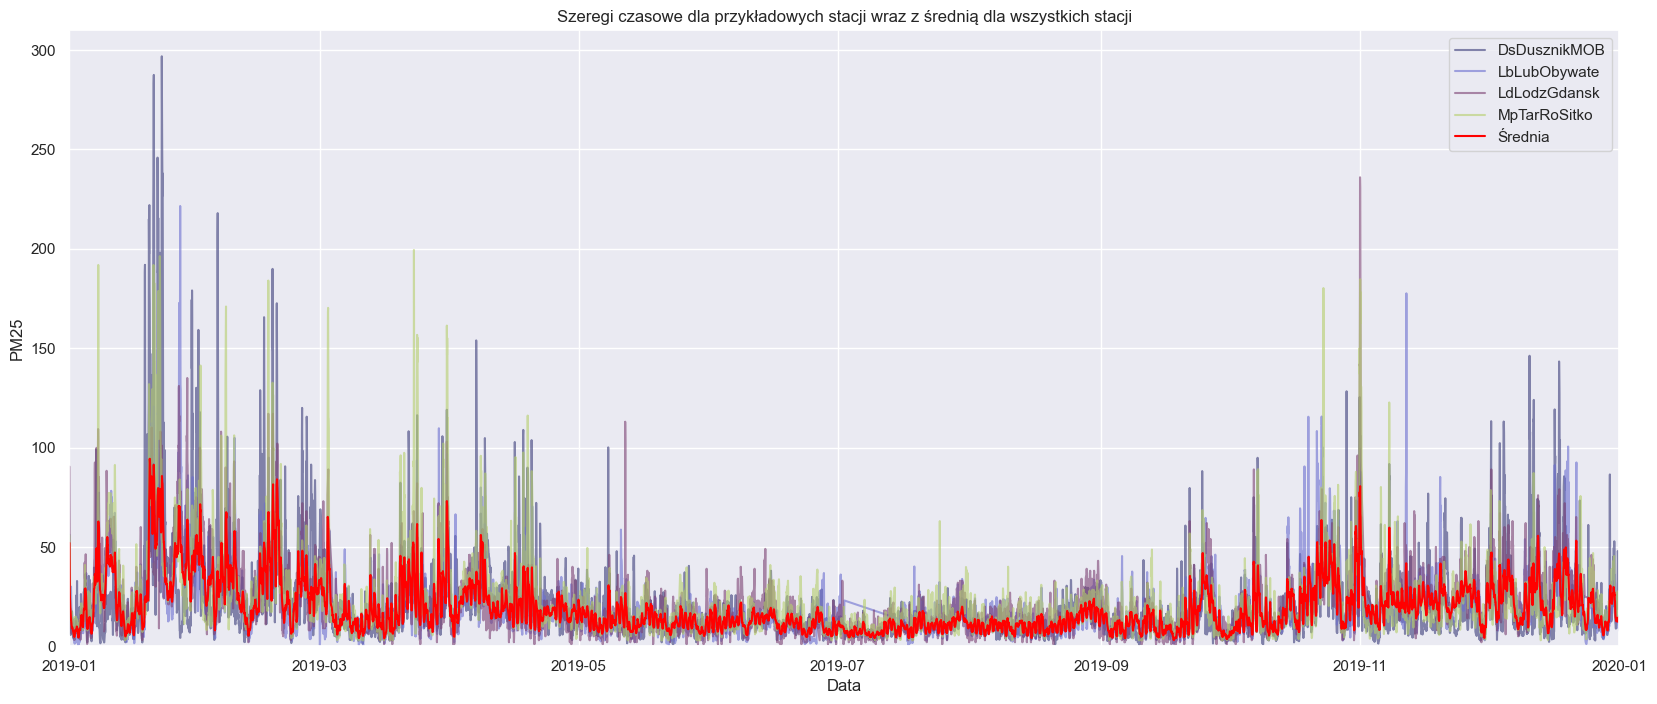

In [11]:
temp_stations_list = ["DsDusznikMOB", "LbLubObywate", "LdLodzGdansk", "MpTarRoSitko"]

tab20b = mpl.colormaps["tab20b"]
palette_personalized = [tab20b(0 / 16), tab20b(2 / 16), tab20b(13 / 16), tab20b(5 / 16)]


temp = df[df.station_code.isin(temp_stations_list)]

means = df.groupby("date")["PM25"].mean()

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.lineplot(
    x=temp.date,
    y=temp.PM25,
    hue=temp.station_code,
    alpha=0.6,
    palette=palette_personalized,
    ax=ax,
)
sns.lineplot(x=means.index, y=means.values, ax=ax, color="red", label="Średnia")

ax.set(
    title="Szeregi czasowe dla przykładowych stacji wraz z średnią dla wszystkich stacji",
    xlabel="Data",
    ylabel="PM25",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01")],
    ylim=[0, 310],
)

plt.show()

Powyżej przedstawiono szeregi czasowe dla czterech przykładowych stacji, wraz ze średnią zanieczyszczeń dla **wszystkich** stacji. Co warto zauważyć:
- Ogólny trend jest praktycznie identyczny - w tych samych dniach następują wzrosty/spadki
- Pomimo faktu, że wybrane stacje są od siebie znacznie oddalone geograficznie, nie występują między nimi zbyt duże różnice w amplitudzie wartości zanieczyszczeń

### Dodawanie cech (czas)

Następnym etapem było dodanie cech związanych z czasem.

#### Cechy z daty
 W pierwszej kolejności postanowiono dodać cechy wynikające bezpośrednio z daty, takie jak dzień tygodnia.
 

In [12]:
df.loc[:, "month"] = df["date"].dt.month
df.loc[:, "day"] = df["date"].dt.day
df.loc[:, "day_of_week"] = df["date"].dt.day_of_week
df.loc[:, "day_of_year"] = df["date"].dt.day_of_year
df.loc[:, "hour"] = df["date"].dt.hour

df.head()

C:\Users\ewa.szewczyk\AppData\Local\Temp\ipykernel_18052\3867945377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "month"] = df["date"].dt.month
C:\Users\ewa.szewczyk\AppData\Local\Temp\ipykernel_18052\3867945377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "day"] = df["date"].dt.day
C:\Users\ewa.szewczyk\AppData\Local\Temp\ipykernel_18052\3867945377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,day,day_of_week,day_of_year,hour
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,1
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,2
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,3
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,4
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,5


Aby móc dodać bardziej zaawansowane cechy związane z czasem, konieczne jest pozbycie się wartości brakujących ze zbioru danych tak, aby te brakujące wartości nie były później powielane.

#### Dane brakujące
Najpierw sprawdzono, ile i jakiego rodzaju jest danych brakujących.

In [13]:
# Sprawdzenie ilości brakujących danych

print(
    f'Procent brakujących danych w kolumnie PM25: {round(df["PM25"].isna().sum()/len(df)*100,2)}%'
)

Procent brakujących danych w kolumnie PM25: 4.43%


In [14]:
# Stworzenie ramki tylko z danymi brakującymi
only_missing = df[df.PM25.isna()]

only_missing.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,day,day_of_week,day_of_year,hour
492,2019-01-21 13:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,21,0,21,13
1379,2019-02-27 12:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,2,27,2,58,12
1504,2019-03-04 17:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,4,0,63,17
1505,2019-03-04 18:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,4,0,63,18
1655,2019-03-11 00:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,11,0,70,0


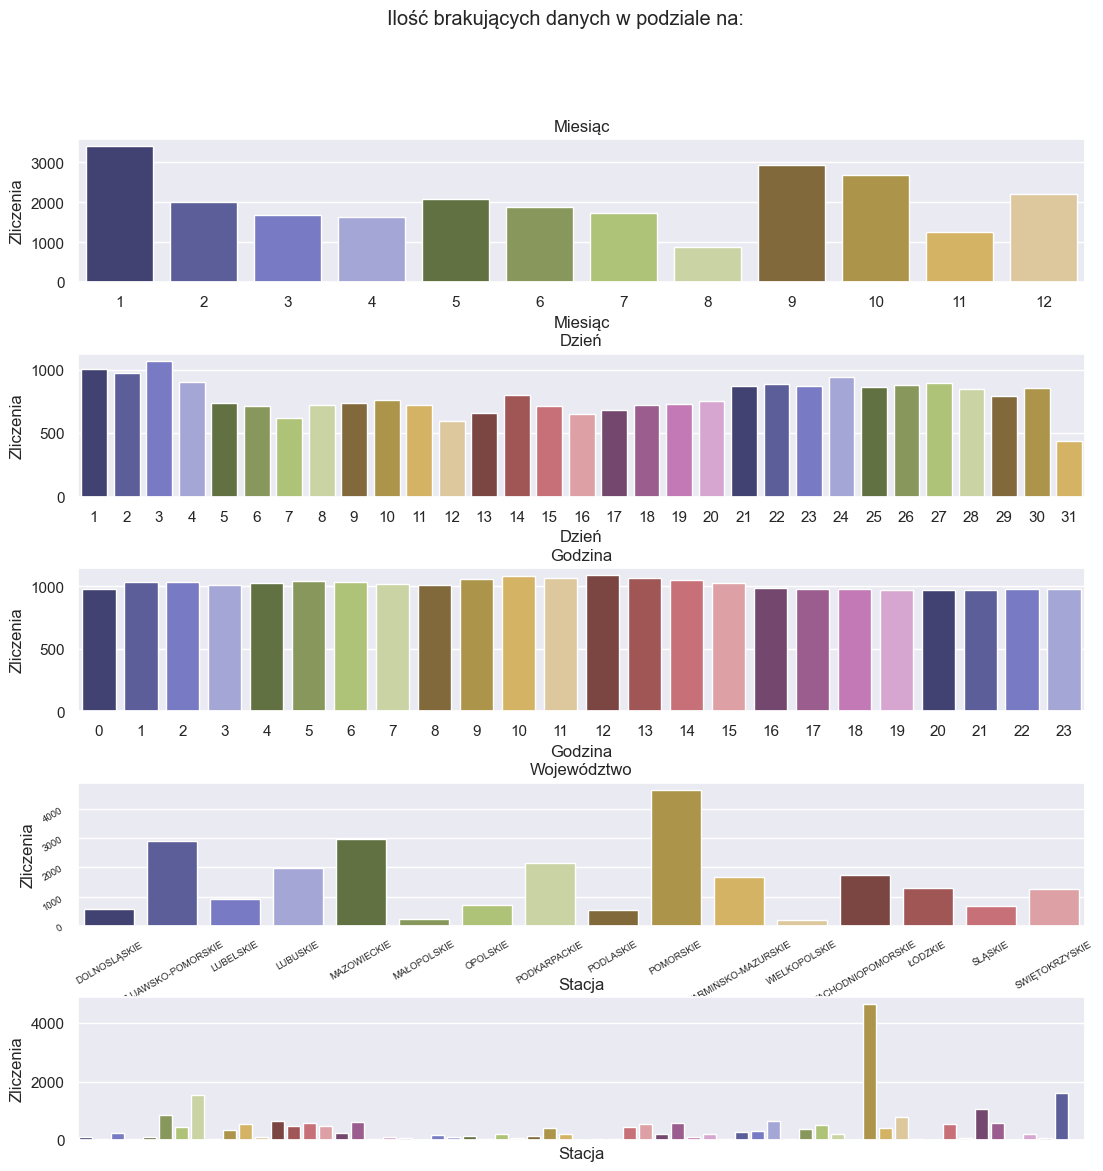

In [15]:
cols_to_check = ["month", "day", "hour", "voivodeship", "station_code"]
plot_names = ["Miesiąc", "Dzień", "Godzina", "Województwo", "Stacja"]

fig, axes = plt.subplots(len(cols_to_check), 1, figsize=(13, 13))

for i, col in enumerate(cols_to_check):
    temp = only_missing.groupby(col)["station_code"].count()
    sns.barplot(
        x=temp.index, y=temp.values, ax=axes[i], palette="tab20b", hue=temp.index
    )
    axes[i].set(title=plot_names[i], xlabel=plot_names[i], ylabel="Zliczenia")

    if axes[i].get_legend() is not None:
        axes[i].get_legend().remove()


axes[3].tick_params(rotation=30, labelsize=7)

fig.suptitle("Ilość brakujących danych w podziale na:")
plt.subplots_adjust(hspace=0.5)
plt.xticks([])

plt.show()

W związku z analizą powyższych wykresów można wyciągnąć następujące wnioski na temat danych brakujących:
- Nie istnieje większy związek między datą czy godziną pomiaru a brakiem zebrania takowego pomiaru
- Najwięcej danych brakuje ze stacji pomiarowych w województwie pomorskim, pomimo faktu, że w tamtym województwie znajduje się tylko jedna stacja pomiarowa
- Dla niektórych stacji brakuje bardzo dużej ilości danych, co sugeruje na brak losowości w braku danych.

In [16]:
# Sprawdzenie stacji z największą ilością brakujących danych
onms_counts = only_missing.station_code.value_counts()

onms_counts

station_code
PmGdaLeczkow        4648
ZpSzczBudzWosMOB    1620
KpToruDziewu        1547
WmElbBazynsk        1055
KpBydPlPozna         849
                    ... 
ZpSzczPilsud          25
SlBielPartyz          20
MpTarRoSitko          12
PkRzeszPilsu          11
WmOlsPuszkin           2
Name: count, Length: 63, dtype: int64

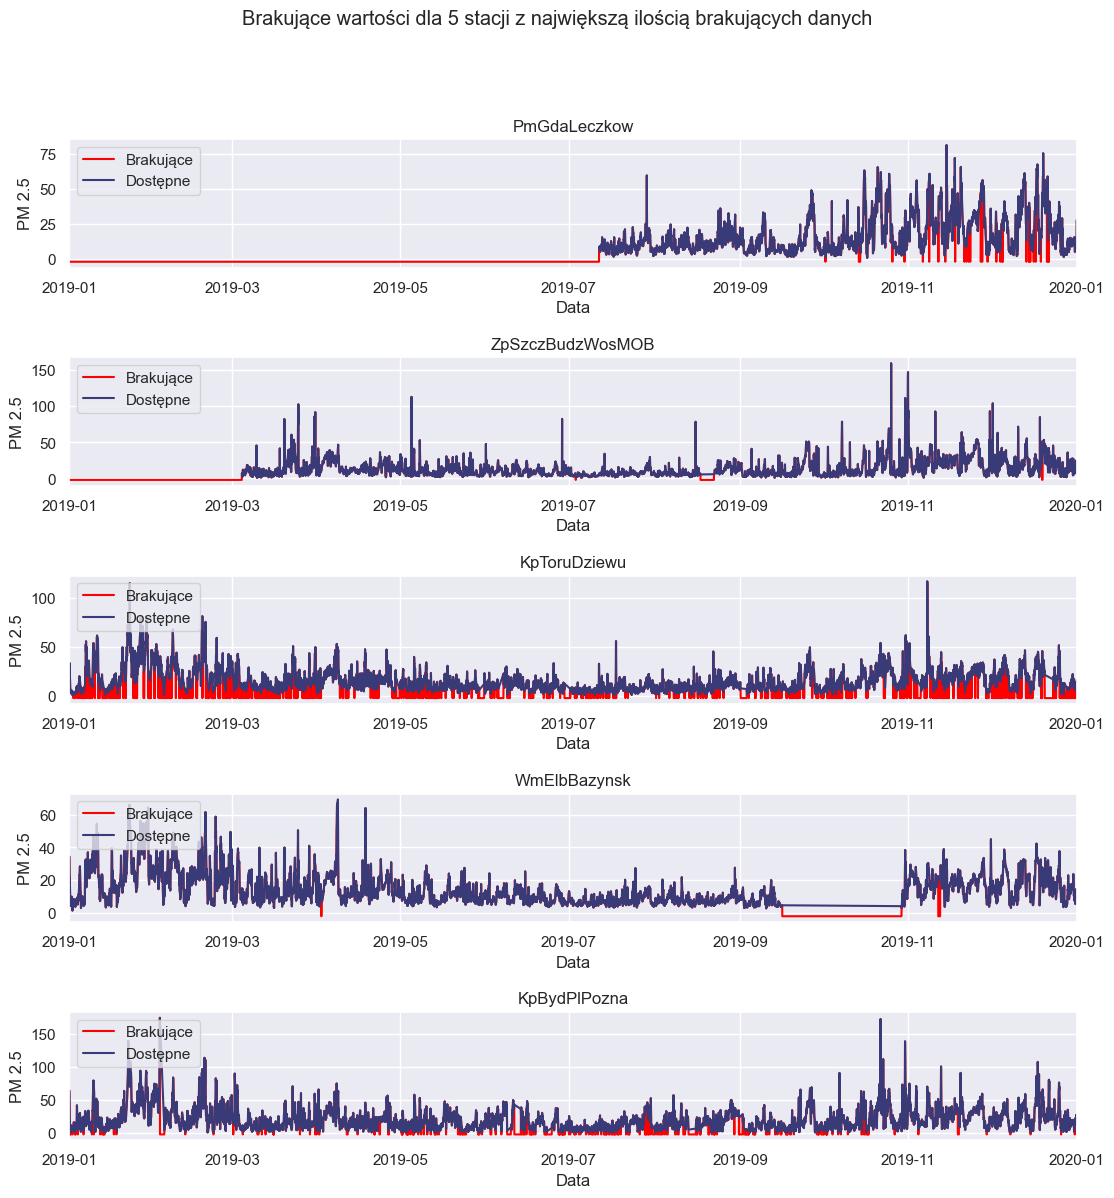

In [17]:
# Wykres pierwszych 5
onms_5 = onms_counts[:5]

fig, axes = plt.subplots(5, 1, figsize=(13, 13))

for i, station in enumerate(onms_5.index):
    temp = df[df.station_code == station]
    na_s = temp["PM25"].fillna(-2)

    sns.lineplot(x=temp.date, y=na_s, color="red", ax=axes[i], label="Brakujące")
    sns.lineplot(x=temp.date, y=temp.PM25, ax=axes[i], label="Dostępne")
    axes[i].set(
        xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01")],
        xlabel="Data",
        ylabel="PM 2.5",
        title=station,
    )
    axes[i].legend(loc="upper left")

fig.suptitle("Brakujące wartości dla 5 stacji z największą ilością brakujących danych")
fig.subplots_adjust(hspace=0.7)

plt.show()

Powyżej zaprezentowano szeregi czasowe dla 5 czujników które posiadają największą ilość danych brakujących. Kolorem czerwonym zaznaczono brakuące dane.
Można zauważyć, że w przypadku 3 stacji okresy braku danych były dłuższe. Sugerują one dłuższy czas braku użytkowania stacji.
W pozostałych przypadkach brak danych wydaje się być błędem systematycznym/losowym, jednak okresy braku danych nie są zbyt długie.

##### 1. Uzupełnianie przez interpolację (do 48 godzin)
Uzupełnianie danych postanowiono przeprowadzić w trzech krokach. Pierwszym z nich było uzupełnienie danych, jeśli okres braku danych nie przekraczał 48 godzin, przez interpolację. Dzięki temu uzyskano zmniejszenie procenta brakujących danych do 2.7.

In [18]:
filled_df = df.copy()
filled_df["PM25"] = (
    df.groupby("station_code")["PM25"]
    .apply(lambda x: x.fillna(x.interpolate(limit=48)))
    .reset_index(drop=True)
)
print(
    f'Procent brakujących danych w kolumnie PM25: {round(filled_df["PM25"].isna().sum()/len(filled_df)*100,2)}%'
)

Procent brakujących danych w kolumnie PM25: 2.7%


##### 2. Uzupełnianie przez średnią wojewódzką
Jako drugi krok na podstawie przykładowego województwa sprawdzono, na ile różnią się od siebie szeregi czasowe czujników znajdujących się w tym samym województwie. Ponieważ wyniki były zadowalające postanowieniu o uzupełnieniu w ten sposób dłuższych okresów braku danych.

In [19]:
filled_df.groupby("voivodeship")["station_code"].nunique()

voivodeship
DOLNOŚLĄSKIE            5
KUJAWSKO-POMORSKIE      4
LUBELSKIE               2
LUBUSKIE                4
MAZOWIECKIE            15
MAŁOPOLSKIE             4
OPOLSKIE                2
PODKARPACKIE            7
PODLASKIE               3
POMORSKIE               1
WARMIŃSKO-MAZURSKIE     3
WIELKOPOLSKIE           1
ZACHODNIOPOMORSKIE      3
ŁÓDZKIE                 3
ŚLĄSKIE                 3
ŚWIĘTOKRZYSKIE          3
Name: station_code, dtype: int64

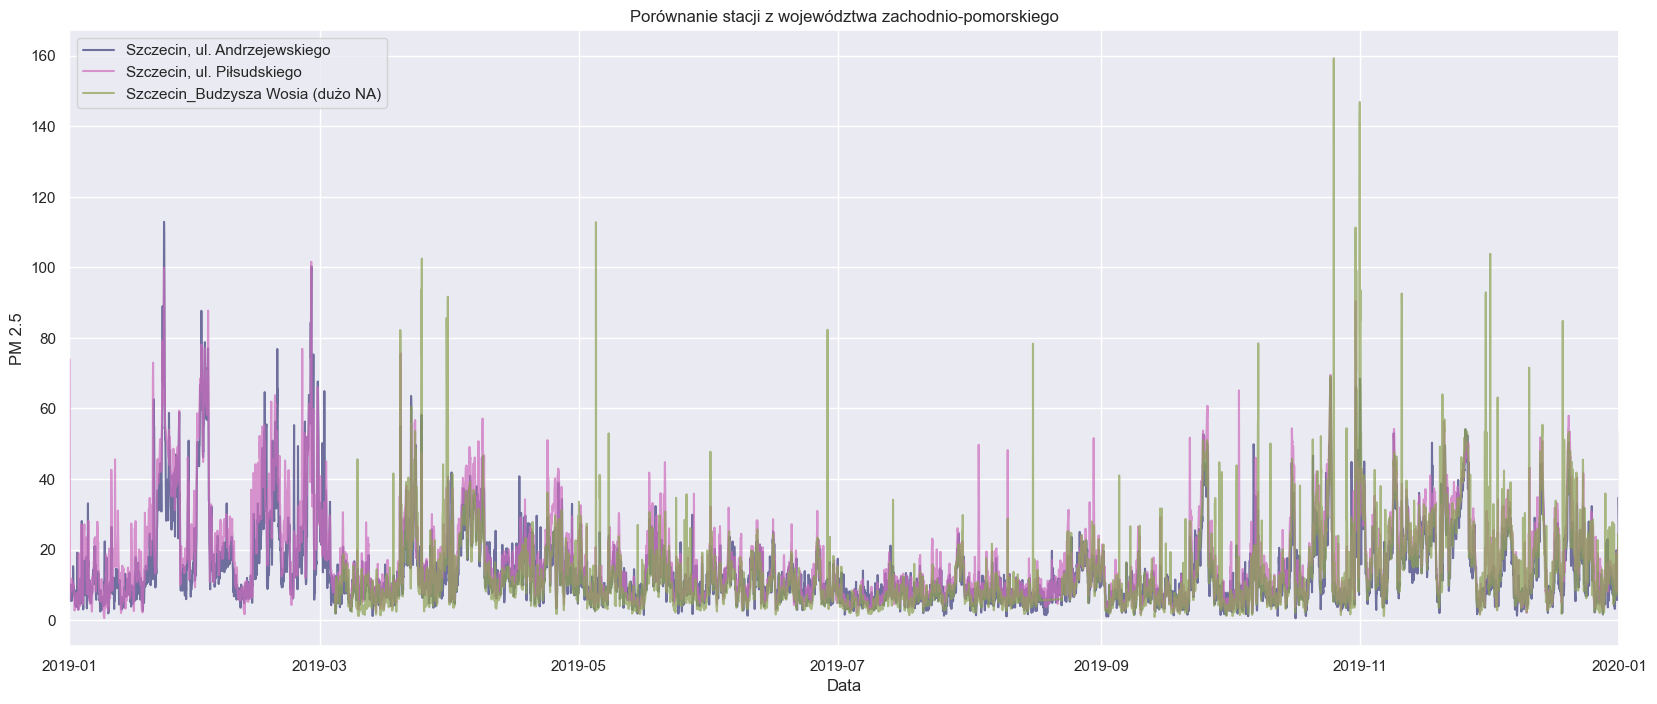

In [20]:
temp = filled_df[filled_df.station_code == "ZpSzczAndrze"]
temp2 = filled_df[filled_df.station_code == "ZpSzczBudzWosMOB"]
temp3 = filled_df[filled_df.station_code == "ZpSzczPilsud"]

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(
    x=temp.date,
    y=temp.PM25,
    ax=ax,
    label="Szczecin, ul. Andrzejewskiego",
    color=tab20b(0 / 16),
    alpha=0.7,
)
sns.lineplot(
    x=temp3.date,
    y=temp3.PM25,
    ax=ax,
    label="Szczecin, ul. Piłsudskiego",
    color=tab20b(15 / 16),
    alpha=0.7,
)
sns.lineplot(
    x=temp2.date,
    y=temp2.PM25,
    ax=ax,
    label="Szczecin_Budzysza Wosia (dużo NA)",
    color=tab20b(4 / 16),
    alpha=0.7,
)

ax.set(
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01")],
    xlabel="Data",
    ylabel="PM 2.5",
    title="Porównanie stacji z województwa zachodnio-pomorskiego",
)

plt.show()

In [21]:
filled_region_df = filled_df.copy()

grouped = filled_df.groupby(["date", "voivodeship"])["PM25"].mean()

filled_region_df["PM25"] = filled_df.apply(
    lambda row: (
        grouped.loc[(row["date"], row["voivodeship"])]
        if pd.isna(row["PM25"])
        else row["PM25"]
    ),
    axis=1,
)

print(
    f'Procent brakujących danych w kolumnie PM25: {round(filled_region_df["PM25"].isna().sum()/len(filled_region_df)*100,2)}%'
)

Procent brakujących danych w kolumnie PM25: 0.83%


##### 3. Uzupełnianie reszty brakujących danych
Na tym etapie pozostała jedynie jedna stacja w której brakowało danych - była to stacja znajdująca się w województwie pomorskim, w którym nie znajduje się żadna inna stacja. Dodatkowo, dane brakujące przekraczały procentowo ilość dostępnych danych. W związku z tym, że nie było możliwe efektywne uzupełnienie danych brakujących dla tego szeregu postanowiono o usunięciu tej stacji z ramki danych.

station_code
PmGdaLeczkow    4606
Name: count, dtype: int64


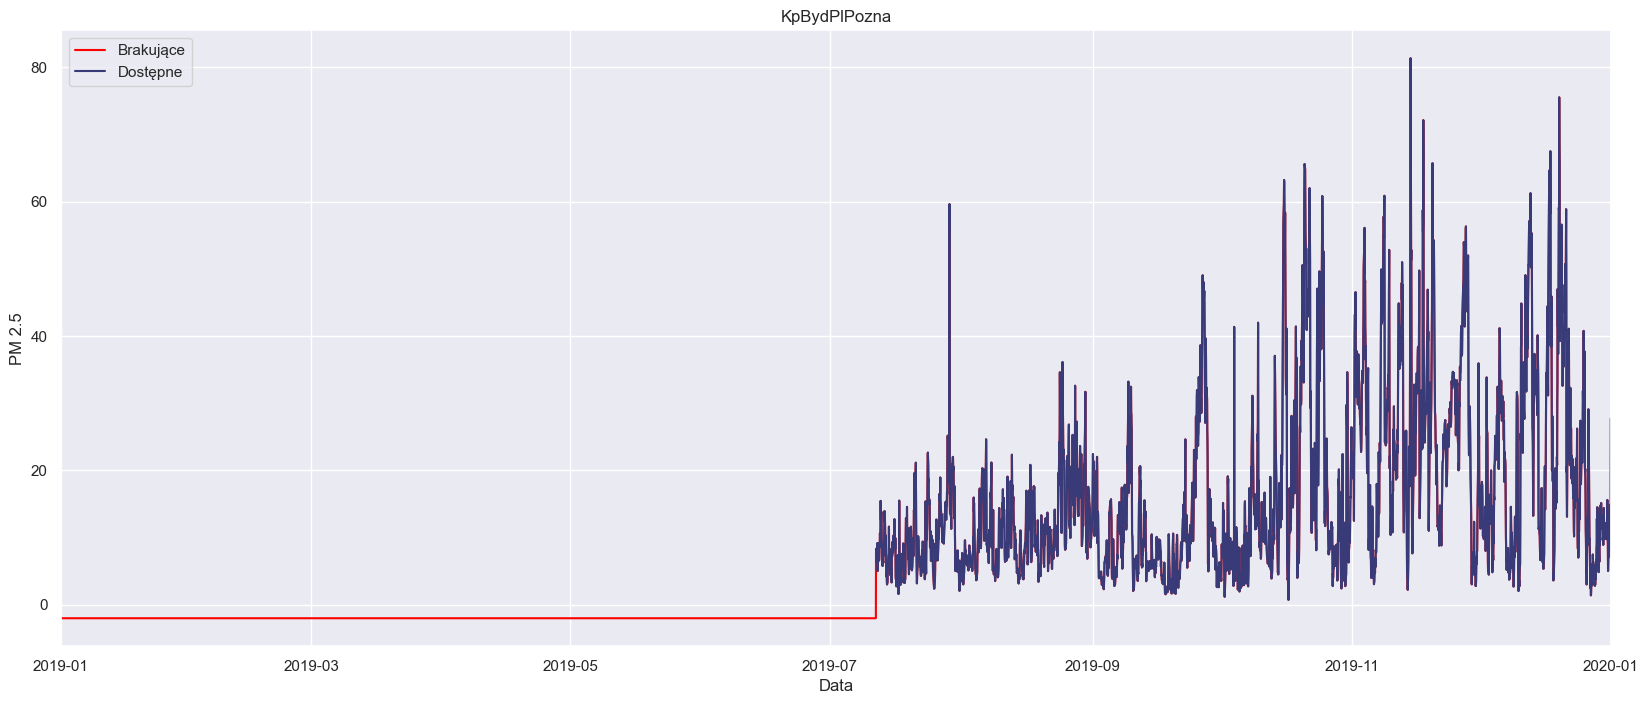

In [22]:
# Sprawdzenie gdzie jeszcze nie ma danych
only_missing = filled_region_df[filled_region_df.PM25.isna()]

print(only_missing.station_code.value_counts())

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

temp = filled_region_df[
    filled_region_df.station_code == only_missing.station_code.unique()[0]
]
na_s = temp["PM25"].fillna(-2)

sns.lineplot(x=temp.date, y=na_s, color="red", ax=ax, label="Brakujące")
sns.lineplot(x=temp.date, y=temp.PM25, ax=ax, label="Dostępne")
ax.set(
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01")],
    xlabel="Data",
    ylabel="PM 2.5",
    title=station,
)
ax.legend(loc="upper left")

plt.show()

In [23]:
df_cleaned = filled_region_df[filled_region_df.station_code != "PmGdaLeczkow"]

print(
    f'Procent brakujących danych w kolumnie PM25: {round(df_cleaned["PM25"].isna().sum()/len(df_cleaned)*100,2)}%'
)

Procent brakujących danych w kolumnie PM25: 0.0%


#### Cechy w oknach czasowych oraz oparte na opóźnieniach wartości pyłu

##### Cechy oparte na opóźnieniach

W celach testowych, najpierw sprawdzono szereg czasowy dla jednej stacji, z jednego miesiąca.

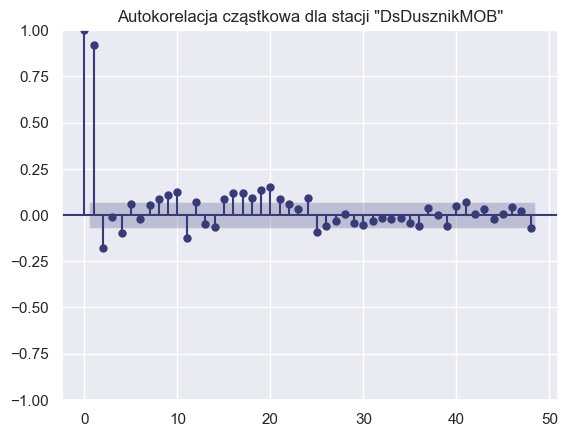

In [24]:
temp = df_cleaned[df_cleaned.station_code == "DsDusznikMOB"]
temp = temp.set_index("date")
temp = temp.loc["2019-01"]

plot_pacf(temp.PM25, lags=48, title='Autokorelacja cząstkowa dla stacji "DsDusznikMOB"')
plt.show()

Z powyższego wykresu autokorelacji cząstkowej można zauważyć, że największy wpływ na wartość PM2.5 mają pierwsze 3 godziny, a także odczyty sprzed około doby.

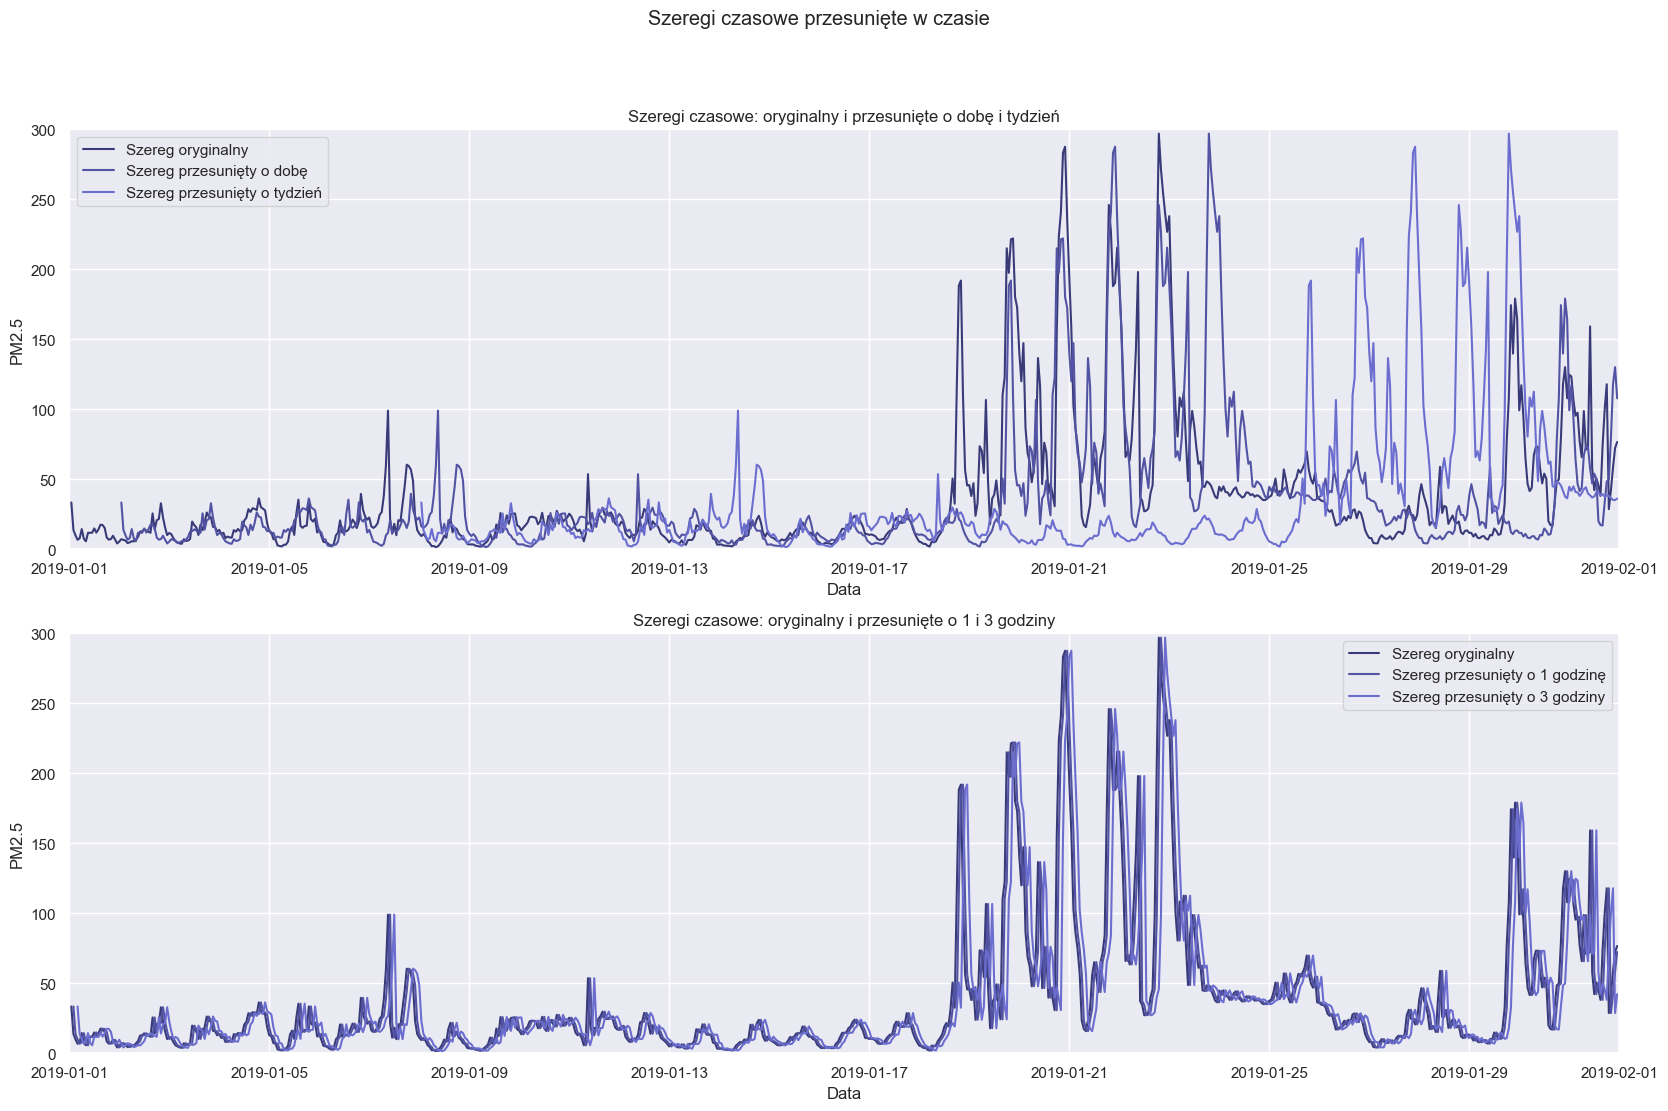

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))


sns.lineplot(x=temp.index, y=temp.PM25, ax=axes[0], label="Szereg oryginalny")
sns.lineplot(
    x=temp.index, y=temp.PM25.shift(24), ax=axes[0], label="Szereg przesunięty o dobę"
)


sns.lineplot(
    x=temp.index,
    y=temp.PM25.shift(24 * 7),
    ax=axes[0],
    label="Szereg przesunięty o tydzień",
)
axes[0].set(
    title="Szeregi czasowe: oryginalny i przesunięte o dobę i tydzień",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2019-02-01")],
    ylim=[0, 300],
)

sns.lineplot(x=temp.index, y=temp.PM25, ax=axes[1], label="Szereg oryginalny")
sns.lineplot(
    x=temp.index,
    y=temp.PM25.shift(1),
    ax=axes[1],
    label="Szereg przesunięty o 1 godzinę",
)
sns.lineplot(
    x=temp.index,
    y=temp.PM25.shift(3),
    ax=axes[1],
    label="Szereg przesunięty o 3 godziny",
)
axes[1].set(
    title="Szeregi czasowe: oryginalny i przesunięte o 1 i 3 godziny",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2019-02-01")],
    ylim=[0, 300],
)

fig.suptitle("Szeregi czasowe przesunięte w czasie")

plt.show()

Do ramki danych postanowiono dodać opóźnienia 1, 2 i 3 godzinne jako te, które wykazały największą korelację na wykresie autokorelacji cząstkowej, a także szereg przesunięty o 24 godziny i o tydzień - w związku z możliwą sezonowością dobową (większe zanieczyszczenia w czasie dojazdów do pracy) i tygodniową (Większe zanieczyszczenia w dni robocze)

In [26]:
stations_unique = df_cleaned.station_code.unique()
df_lags = df_cleaned.copy()
lags = pd.DataFrame()

for station in stations_unique:
    temp = df_lags[df_lags.station_code == station].set_index("date")

    temp["h1"] = temp.PM25.shift(1)
    temp["h2"] = temp.PM25.shift(2)
    temp["h3"] = temp.PM25.shift(3)
    temp["d1"] = temp.PM25.shift(24)
    temp["w1"] = temp.PM25.shift(24 * 7)

    temp = temp.reset_index(drop=False)
    cols_to_leave = ["date", "station_code", "h1", "h2", "h3", "d1", "w1"]
    temp = temp[cols_to_leave]

    lags = pd.concat([lags, temp])

df_lags = df_lags.merge(lags, how="left", on=["date", "station_code"])

df_lags.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,day,day_of_week,day_of_year,hour,h1,h2,h3,d1,w1
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,2,33.40530,NaN,NaN,NaN,NaN
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,3,13.80280,33.40530,NaN,NaN,NaN
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,4,9.94056,13.80280,33.4053,NaN,NaN
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,5,6.75889,9.94056,13.8028,NaN,NaN


##### Cechy w oknach

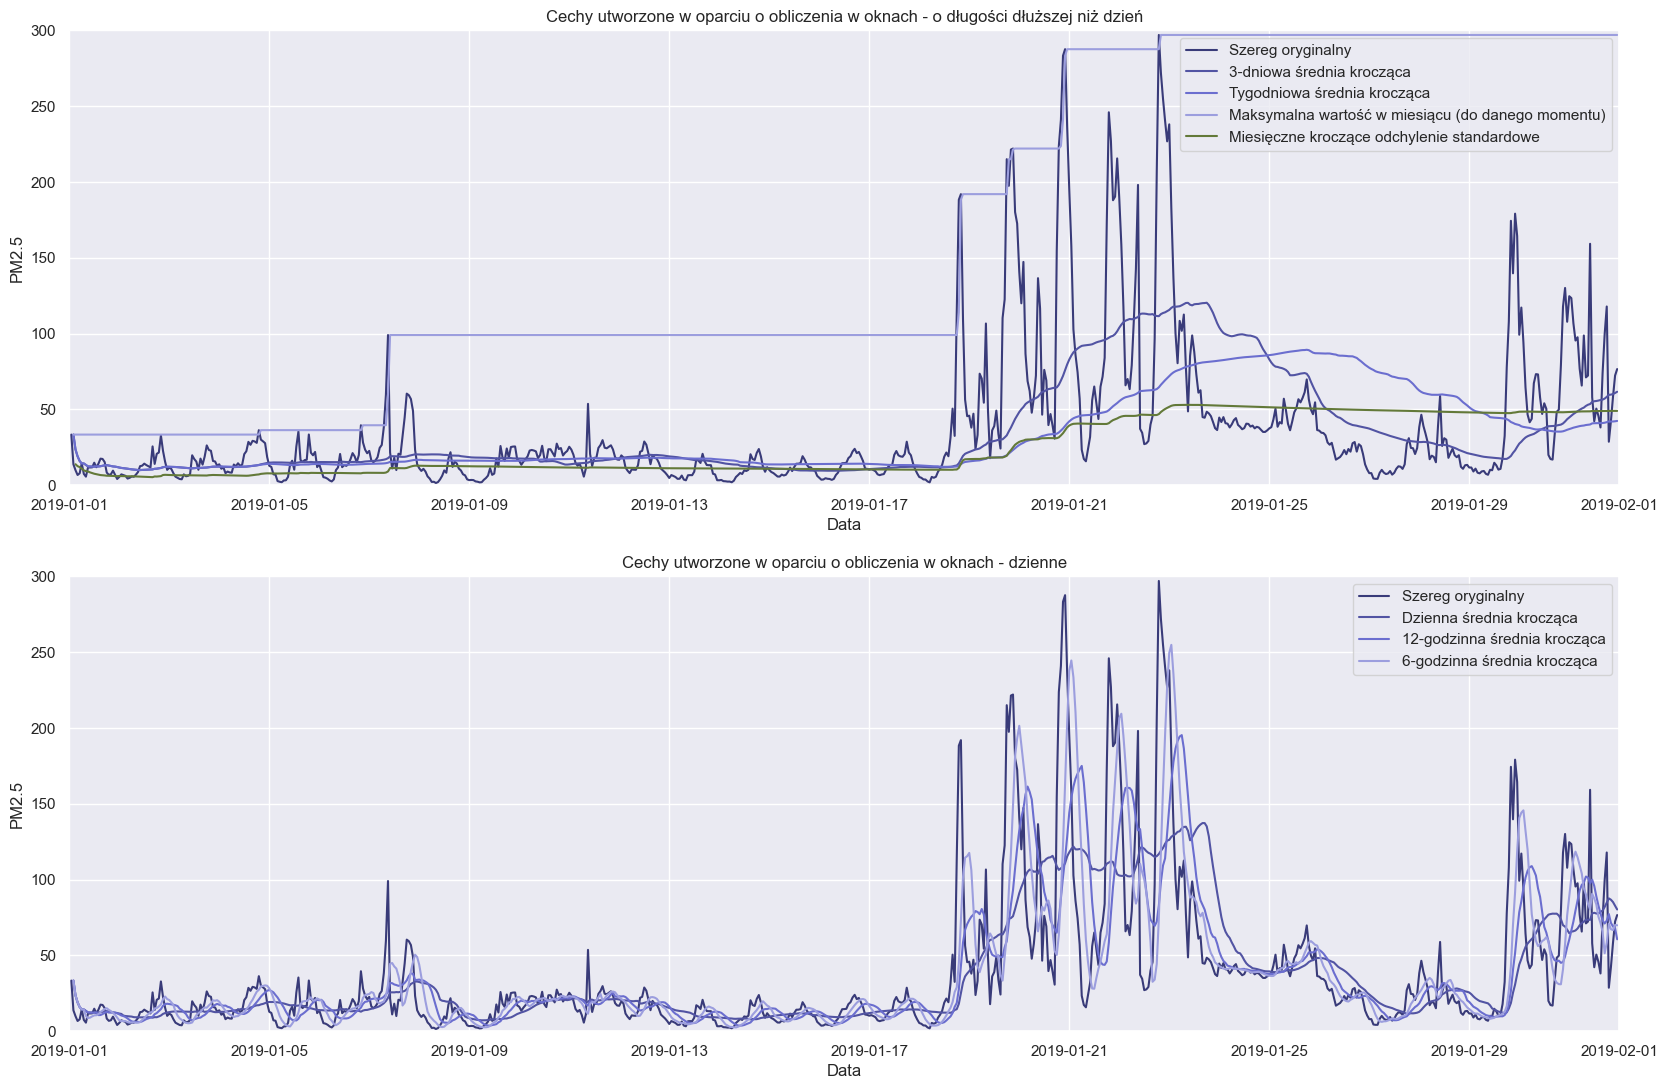

In [27]:
temp = df_lags[df_lags.station_code == "DsDusznikMOB"]
temp = temp.set_index("date")
temp = temp.loc["2019-01"]

d3_mean = temp.PM25.rolling(window="3D", closed="left").mean()  # zamiast shift
weekly_mean = temp.PM25.rolling(window="7D", closed="left").mean()
month_std = temp.PM25.rolling(window="30D", closed="left").std()
month_max = temp.PM25.rolling(window="30D", closed="left").max()
d1_mean = temp.PM25.rolling(window="1D", closed="left").mean()
h12_mean = temp.PM25.rolling(window="12h", closed="left").mean()
h6_mean = temp.PM25.rolling(window="6h", closed="left").mean()


temp["d3_mean"] = d3_mean
temp["weekly_mean"] = weekly_mean
temp["month_max"] = month_max
temp["month_std"] = month_std
temp["d1_mean"] = d1_mean
temp["h12_mean"] = h12_mean
temp["h6_mean"] = h6_mean

fig, axes = plt.subplots(2, 1, figsize=(20, 13))

sns.lineplot(x=temp.index, y=temp.PM25, ax=axes[0], label="Szereg oryginalny")
sns.lineplot(
    x=temp.index, y=temp.d3_mean, ax=axes[0], label="3-dniowa średnia krocząca"
)
sns.lineplot(
    x=temp.index, y=temp.weekly_mean, ax=axes[0], label="Tygodniowa średnia krocząca"
)
sns.lineplot(
    x=temp.index,
    y=temp.month_max,
    ax=axes[0],
    label="Maksymalna wartość w miesiącu (do danego momentu)",
)
sns.lineplot(
    x=temp.index,
    y=temp.month_std,
    ax=axes[0],
    label="Miesięczne kroczące odchylenie standardowe",
)

sns.lineplot(x=temp.index, y=temp.PM25, ax=axes[1], label="Szereg oryginalny")
sns.lineplot(x=temp.index, y=temp.d1_mean, ax=axes[1], label="Dzienna średnia krocząca")
sns.lineplot(
    x=temp.index, y=temp.h12_mean, ax=axes[1], label="12-godzinna średnia krocząca"
)
sns.lineplot(
    x=temp.index, y=temp.h6_mean, ax=axes[1], label="6-godzinna średnia krocząca"
)

axes[0].set(
    title="Cechy utworzone w oparciu o obliczenia w oknach - o długości dłuższej niż dzień",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2019-02-01")],
    ylim=[0, 300],
)
axes[1].set(
    title="Cechy utworzone w oparciu o obliczenia w oknach - dzienne",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2019-02-01")],
    ylim=[0, 300],
)

plt.show()

Z cech utworzonych w oparciu o okna czasowe postanowiono do zbioru danych dołączyć:
- dobową średnią kroczącą - ponieważ dobrze odzwierciedla trendy dzienne
- 12-godzinną średnią kroczącą - ponieważ dodatkowo pokazuje różnice na przestrzeni dnia
- 3-dniową średnią kroczącą - pokazuje trend w ciągu ostatnich 3 dni
- miesięczne kroczące odchylenie standardowe - pokazuje na zmienność w danych

In [28]:
stations_unique = df_lags.station_code.unique()
df_rolling = df_lags.copy()
rolls = pd.DataFrame()

for station in stations_unique:
    temp = df_rolling[df_rolling.station_code == station].set_index("date")

    d3_mean = temp.PM25.rolling(window="3D", closed="left").mean()  # zamiast shift
    month_std = temp.PM25.rolling(window="30D", closed="left").std()
    d1_mean = temp.PM25.rolling(window="1D", closed="left").mean()
    h12_mean = temp.PM25.rolling(window="12h", closed="left").mean()

    temp["d3_mean"] = d3_mean
    temp["month_std"] = month_std
    temp["d1_mean"] = d1_mean
    temp["h12_mean"] = h12_mean

    temp = temp.reset_index(drop=False)
    cols_to_leave = [
        "date",
        "station_code",
        "d3_mean",
        "month_std",
        "d1_mean",
        "h12_mean",
    ]
    temp = temp[cols_to_leave]

    rolls = pd.concat([rolls, temp])

df_rolling = df_rolling.merge(rolls, how="left", on=["date", "station_code"])

df_rolling.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,...,hour,h1,h2,h3,d1,w1,d3_mean,month_std,d1_mean,h12_mean
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,...,2,33.40530,NaN,NaN,NaN,NaN,33.405300,NaN,33.405300,33.405300
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,...,3,13.80280,33.40530,NaN,NaN,NaN,23.604050,13.861061,23.604050,23.604050
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,...,4,9.94056,13.80280,33.4053,NaN,NaN,19.049553,12.581527,19.049553,19.049553
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,...,5,6.75889,9.94056,13.8028,NaN,NaN,15.976887,11.970588,15.976887,15.976887


Przed przejściem do następnego etapu konieczne jest również przekodowanie nazw słownych na liczby.

In [29]:
df_encoded = df_rolling.copy()

categorical_columns = [
    "station_type",
    "region_type",
    "station_location_type",
    "voivodeship",
    "station_code",
]

label_encoder = LabelEncoder()

for col in categorical_columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

df_encoded.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,...,hour,h1,h2,h3,d1,w1,d3_mean,month_std,d1_mean,h12_mean
0,2019-01-01 01:00:00,0,33.40530,2,0,1,0,50.402645,16.393319,1,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 02:00:00,0,13.80280,2,0,1,0,50.402645,16.393319,1,...,2,33.40530,NaN,NaN,NaN,NaN,33.405300,NaN,33.405300,33.405300
2,2019-01-01 03:00:00,0,9.94056,2,0,1,0,50.402645,16.393319,1,...,3,13.80280,33.40530,NaN,NaN,NaN,23.604050,13.861061,23.604050,23.604050
3,2019-01-01 04:00:00,0,6.75889,2,0,1,0,50.402645,16.393319,1,...,4,9.94056,13.80280,33.4053,NaN,NaN,19.049553,12.581527,19.049553,19.049553
4,2019-01-01 05:00:00,0,7.88722,2,0,1,0,50.402645,16.393319,1,...,5,6.75889,9.94056,13.8028,NaN,NaN,15.976887,11.970588,15.976887,15.976887


### Podział na zestawy testowe i treningowe

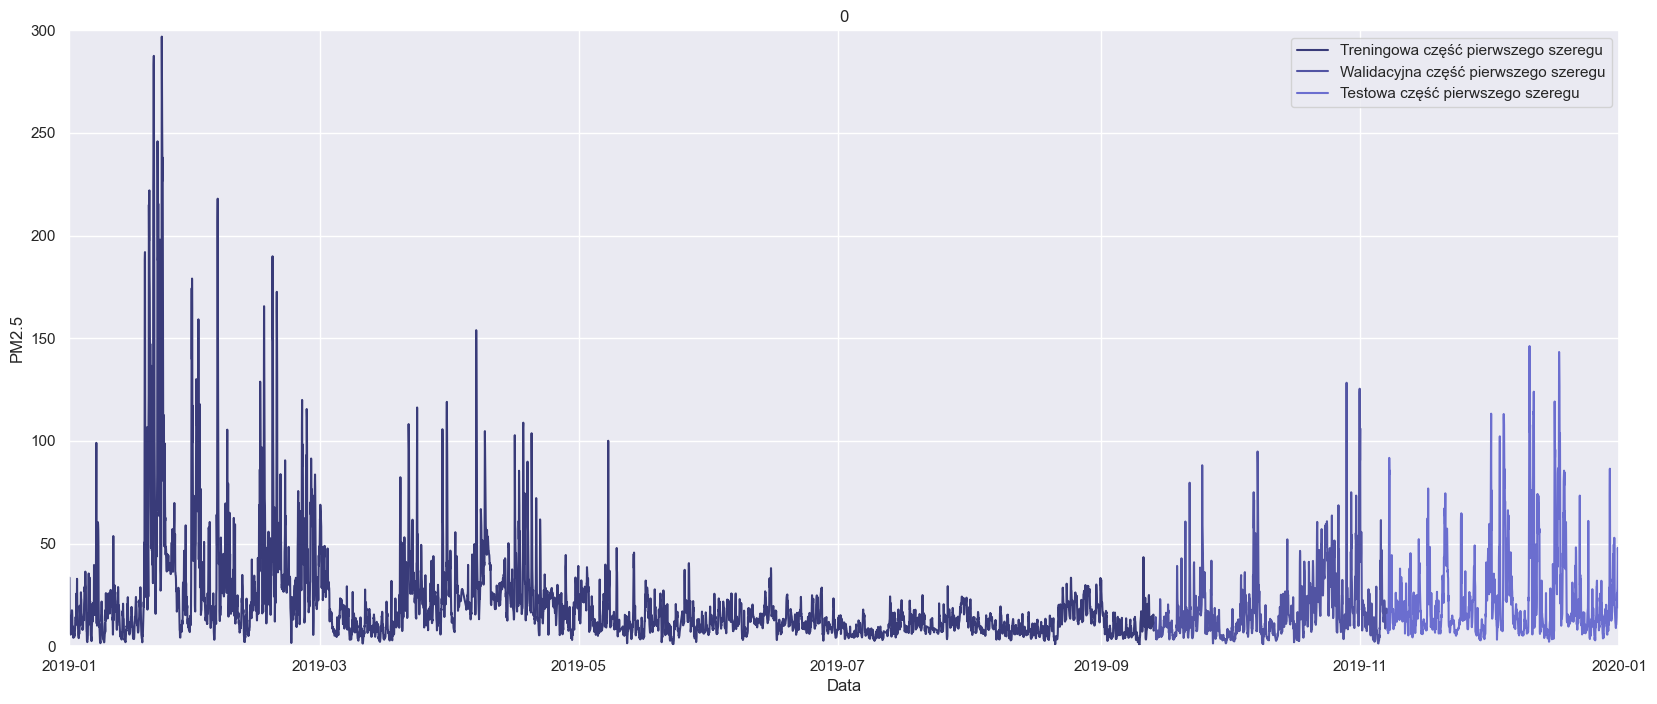

In [30]:
train_list = []
val_list = []
test_list = []

grouped = df_encoded.groupby("station_code")

for station_code, group_df in grouped:
    train_df, temp_df = train_test_split(group_df, test_size=0.3, shuffle=False)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

    train_list.append(train_df)
    val_list.append(val_df)
    test_list.append(test_df)

# Wykres testowo żeby sprawdzić podział
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.lineplot(
    x=train_list[0].date,
    y=train_list[0].PM25,
    ax=ax,
    label="Treningowa część pierwszego szeregu",
)
sns.lineplot(
    x=val_list[0].date,
    y=val_list[0].PM25,
    ax=ax,
    label="Walidacyjna część pierwszego szeregu",
)
sns.lineplot(
    x=test_list[0].date,
    y=test_list[0].PM25,
    ax=ax,
    label="Testowa część pierwszego szeregu",
)

ax.set(
    title=train_list[0].station_code.unique()[0],
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp("2019-01-01"), pd.Timestamp("2020-01-01")],
    ylim=[0, 300],
)

plt.show()

Dane, pogrupowane względem każdej stacji, podzielono najpierw w stosunku 70:30 aby stworzyć zbiór treningowy (70% danych), a następnie dalej podzielono drugi podzbiór na zestaw walidacyjny i testowy w stosunku 50:50. Ostatecznie:
- zbiór treningowy: 70% danych
- zbiór walidacyjny: 15% danych
- zbiór testowy: 15% danych

Dane nie były mieszane ze względu na swoją szerego-czasową naturę.

## Część 2: Tworzenie modelu do predykcji

### Inicjalizacja i trenowanie modelu

Średni błąd RMSE: 8.0


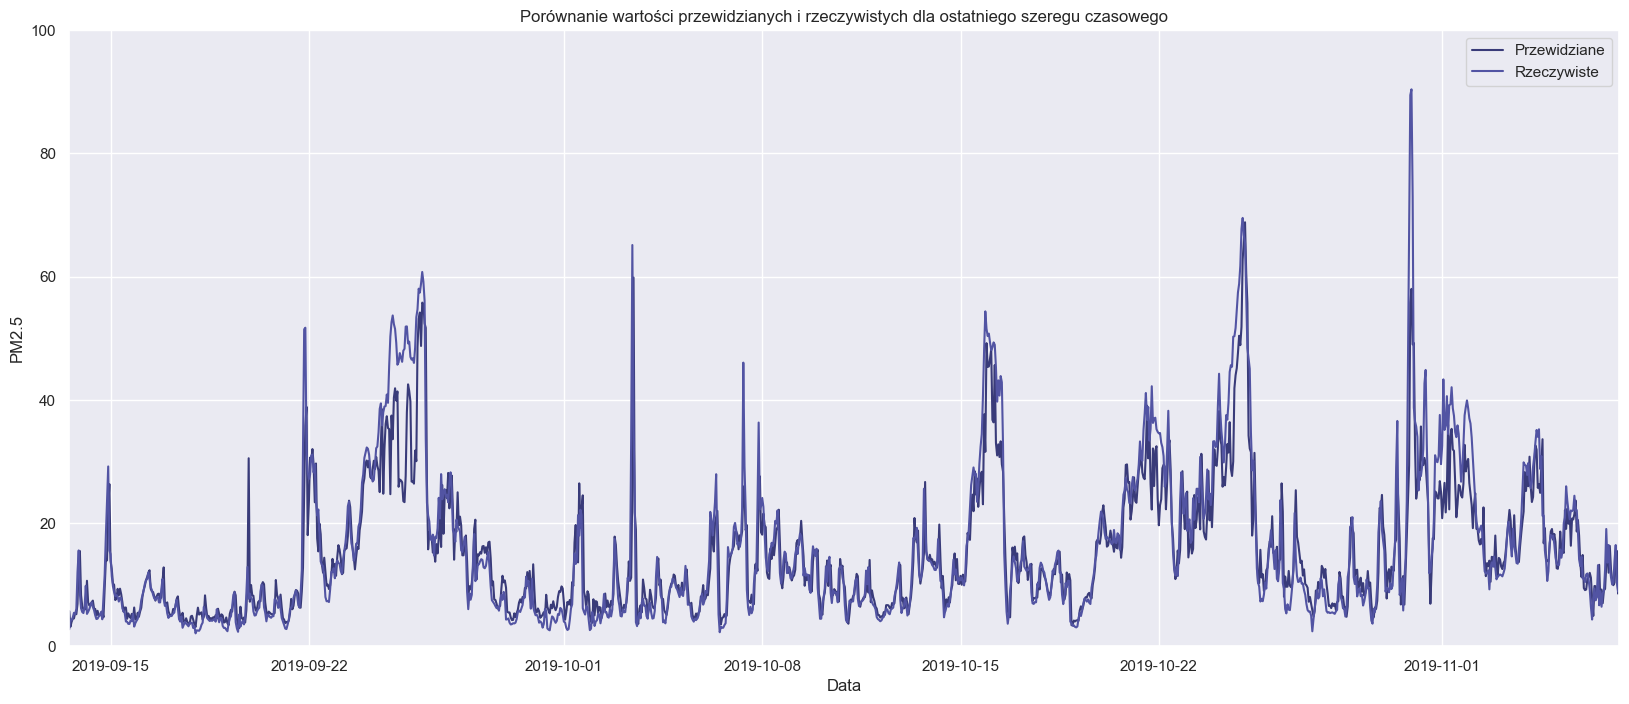

In [50]:
# Inicjalizacja
model = xgb.XGBRegressor()

rmse_list = []

# Trenowanie
for train_df, val_df in zip(train_list, val_list):

    X_train = train_df.drop(["PM25"], axis=1).set_index("date")
    X_val = val_df.drop(["PM25"], axis=1).set_index("date")

    y_train = train_df["PM25"]
    y_val = val_df["PM25"]

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)

    rmse_list.append(mean_squared_error(y_val, predictions) ** 0.5)

print(f"Średni błąd RMSE: {round(np.mean(rmse_list),2)}")

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.lineplot(x=X_val.index, y=predictions, label="Przewidziane")
sns.lineplot(x=X_val.index, y=y_val, label="Rzeczywiste")

ax.set(
    title="Porównanie wartości przewidzianych i rzeczywistych dla ostatniego szeregu czasowego",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp(min(X_val.index)), pd.Timestamp(max(X_val.index))],
    ylim=[0, 100],
)

plt.show()

Średni błąd RMSE dla każdego szeregu walidacyjnego wyniósł 8.0. Powyżej przedstawiono ostatni z szeregów wraz z jego predykcją.
**Plusy i minusy wykorzystania algorytmu XGBRegressor w kontekście predykcji szeregów czasowych:**
| Plusy                                                                | Minusy                                                          |
|----------------------------------------------------------------------|-----------------------------------------------------------------|
| Mocny algorytm mogący poradzić sobie ze skomplikowanymi problemami   | Wrażliwość na hiperparametry                                    |
| Możliwość obsługi dużej liczby cech                                  | Brak możliwości zinterpretowania modelu (model czarna skrzynka) |
| Odporność na overfitting dzięki wbudowanym mechanizmom regularyzacji | Czas uczenia                                                    |

### Tuning hiperparametrów

Dla celów tuningu hiperparametrów postanowiono połączyć wszystkie szeregi czasowe danych treningowych z powrotem w jedną tabelę.

In [54]:
# Połączenie wszystkich danych treningowych w jeden DataFrame
X_train_list = pd.DataFrame()
y_train_list = pd.DataFrame()

for train_df in train_list:
    X_train = train_df.drop(["PM25"], axis=1).set_index("date")
    y_train = train_df["PM25"]

    X_train_list = pd.concat([X_train_list, X_train])
    y_train_list = pd.concat([y_train_list, y_train])

In [55]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.3],
    "n_estimators": [50, 100, 200],
}

model_tuning = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model_tuning, param_grid=param_grid, cv=3)
grid_search.fit(X_train_list, y_train_list)

best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Znalezione w wyniku cross-walidacji najlepsze parametry to: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}. Parametry te następnie użyto do ponownego wytrenowania modelu.

Średni błąd RMSE: 6.88


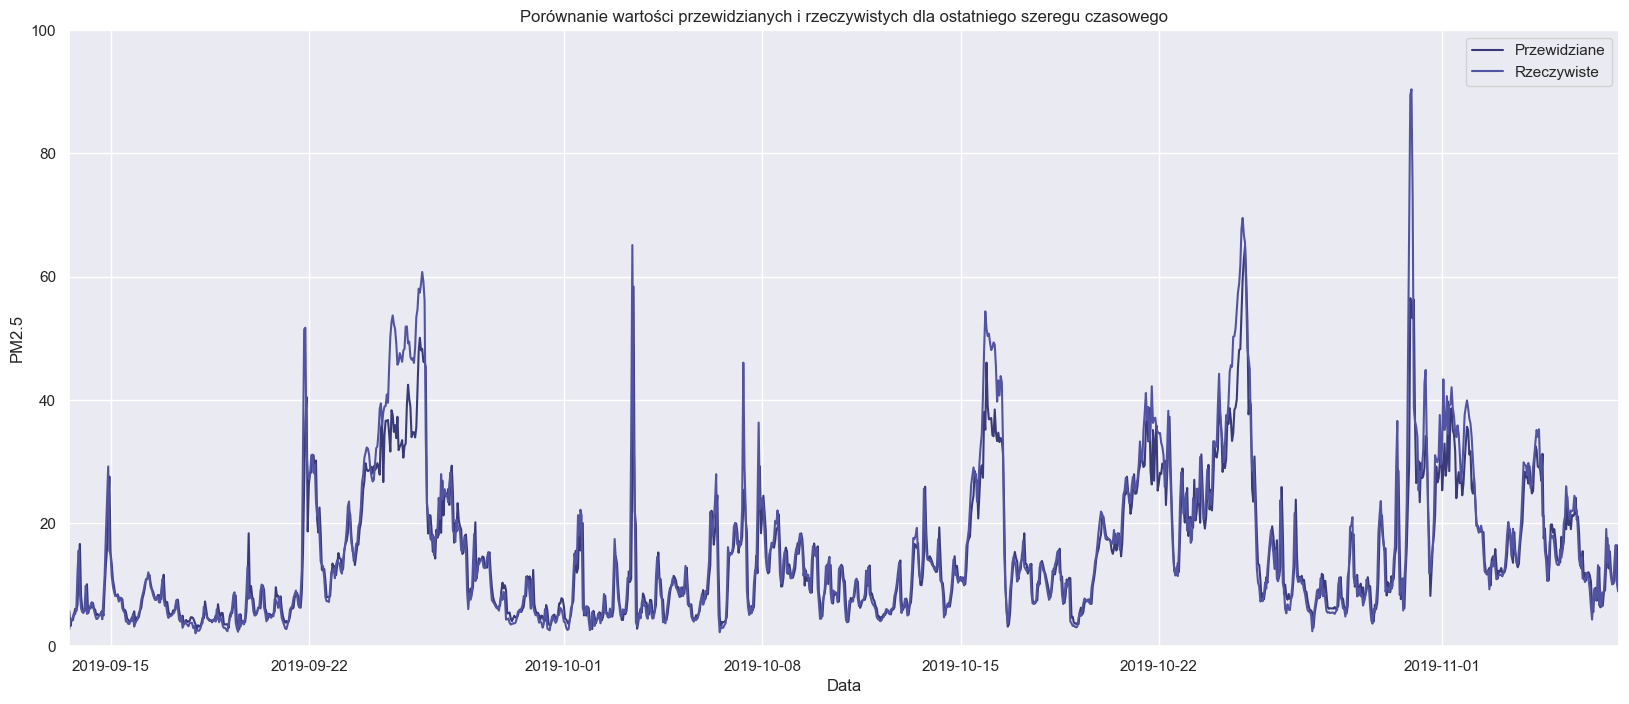

In [56]:
# Inicjalizacja
model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)

rmse_list = []

# Trenowanie
for train_df, val_df in zip(train_list, val_list):

    X_train = train_df.drop(["PM25"], axis=1).set_index("date")
    X_val = val_df.drop(["PM25"], axis=1).set_index("date")

    y_train = train_df["PM25"]
    y_val = val_df["PM25"]

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)

    rmse_list.append(mean_squared_error(y_val, predictions) ** 0.5)

print(f"Średni błąd RMSE: {round(np.mean(rmse_list),2)}")

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.lineplot(x=X_val.index, y=predictions, label="Przewidziane")
sns.lineplot(x=X_val.index, y=y_val, label="Rzeczywiste")

ax.set(
    title="Porównanie wartości przewidzianych i rzeczywistych dla ostatniego szeregu czasowego",
    xlabel="Data",
    ylabel="PM2.5",
    xlim=[pd.Timestamp(min(X_val.index)), pd.Timestamp(max(X_val.index))],
    ylim=[0, 100],
)

plt.show()

Średni błąd RMSE spadł do wartości 6.88, co jest poprawą o 14%. Warto również zauważyć, że sam proces trenowania trwał 2 sekundy krócej (na stacji na której prowadzone były badania) oraz że predykcja dla ostatniego szeregu czasowego jest praktycznie idealna.

**Czym są hiperparametry?**
Hiperparametry to parametry modelu, które nie podlegają nauce w trakcie procesu trenowania modelu, lecz wymagają ustawienia przed rozpoczęciem procesu trenowania. Określają one kluczowe "techniczne" parametry (cechy) modelu takie jak np. maksymalna głębokość drzewa, współczynnik uczenia określający jak "gęsto" poszukiwane są rozwiązania czy liczba estymatorów. Są to w większości parametry stałe, nie ulegające zmianie w trakcie procesu trenowania.

**Dlaczego hiperparametry wymagają tuningu?**
Ich prawidłowe ustalenie jest kluczowe dla poprawności działania modelu. Prawidłowo ustalone mogą znacznie zmniejszyć błąd i na odwrót. Ich wartości są jednak ściśle powiązane z charakterem problemu, jego złożonością i ilością cech, w związku z czym nie jest możliwe stałe ustalenie zestawu wartości hiperparametrów które będą zawsze poprawnie działać (dla każdych danych). Tuning hiperparametrów to proces znajdowania optymalnych wartości hiperparametrów dla modelu. Dzieje się to poprzez eksperymentowanie z różnymi kombinacjami wartości hiperparametrów i ocenianie wyników za pomocą odpowiedniej metryki ewaluacyjnej np. RMSE. 

## Część 3: Backtesting